MHI

In [ ]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [ ]:
def background_subtraction(video, test=False):
  """
  images: a sequence of image in a video
  return: a sequence of image foreground
  		  boolean, means the video is completed or not	
  """
  foregrounds = []
  threshold = 30
  kernel = np.ones((3,3),np.uint8)
  vidcap = cv2.VideoCapture(video)
  last_image = None # estimated background
  while vidcap.isOpened():
    success, image = vidcap.read()
    if success:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
      if last_image is None:
        last_image = image
        continue
      foreground = np.abs(image - last_image)
      foreground[foreground <= threshold] = 0.0
      foreground[foreground > threshold] = 1.0
      clean_foreground = cv2.morphologyEx(foreground, cv2.MORPH_OPEN, kernel)
      foregrounds.append(clean_foreground)
      last_image = image
    else:
      break
  vidcap.release()
  return foregrounds

def build_mhi(foregrounds):
  mhis = []
  init_val = 30
  mhi_0 = np.zeros(foregrounds[0].shape)
  mhi_0[foregrounds[0] == 1] = init_val
  mhis.append(mhi_0)
  for i in range(1, len(foregrounds)):
    mhi_i = np.zeros(foregrounds[0].shape)
    mhi_i[foregrounds[i] == 1] = init_val
    mhi_i[foregrounds[i] == 0] = mhis[i-1][foregrounds[i] == 0] - 1
    mhi_i[mhi_i < 0] = 0
    mhis.append(mhi_i)
  return mhis[-1]

def calcu_humoment(mhi):
	pqs = [(1,1),(2,0),(0,2),(2,1),(1,2),(3,0),(0,3),(2,2)]
	humoment = []
	M00 = np.sum(mhi) + 1 # avoid zero division
	M10 = np.sum(np.array(range(mhi.shape[0])).reshape(-1,1) * mhi)
	M01 = np.sum(np.array(range(mhi.shape[1])) * mhi)
	x_avg = M10 / M00
	y_avg = M01 / M00
	mu = []
	v = []
	for pq in pqs:
	  p, q = pq
	  x = np.power((np.array(range(mhi.shape[0])).reshape(-1,1) - x_avg), p)
	  y = np.power((np.array(range(mhi.shape[1])) - y_avg), q)
	  mu_pq = np.sum(x*(y*mhi))
	  v_pq = mu_pq / np.power(M00, (1+(p+q)/2))
	  mu.append(mu_pq)
	  v.append(v_pq)
	humoment = list(np.concatenate((v,mu)))
	return humoment


1.0 29.0


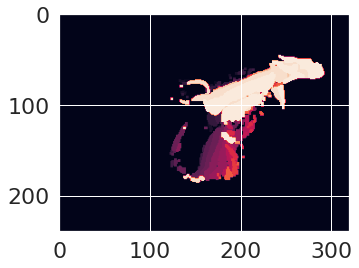

In [ ]:
foregrounds = background_subtraction("/content/ReCompress_Videos/brush_hair/April_09_brush_hair_u_nm_np1_ba_goo_0.avi")
mhi = build_mhi(foregrounds)
plt.imshow(mhi)
print(np.max(foregrounds),np.max(mhi))

In [ ]:
import glob, os

for root, dirs, files in os.walk('/content/ReCompress_Videos'):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)

            print(path)

            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleted...")
                i += 1



In [ ]:
!mkdir /content/JHMDB_MHI
all_actions = os.listdir('/content/ReCompress_Videos/')
for action in all_actions:
    path = '/content/ReCompress_Videos/' + action + '/'
    all_action_videos = os.listdir(path)
    path_to_create = '/content/JHMDB_MHI/' + action  + '/'
    os.mkdir(path_to_create)
    for video in all_action_videos:
        
        video_path = '/content/ReCompress_Videos/' + action + '/' + video
        foregrounds = background_subtraction(video_path)
        mhi = build_mhi(foregrounds)
        cv2.imwrite('/content/JHMDB_MHI/'+action+'/'+video[:-4]+'.jpg', mhi * 8)



Resnet

In [ ]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import accuracy_score
import random
from torch.utils import data
from tqdm import tqdm

import matplotlib.pyplot as plt
import time

# random seed
np.random.seed(11785)
torch.manual_seed(11785)

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
sys.version
print(cuda, sys.version)

True 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
# Check if cuda is available
cuda = torch.cuda.is_available()
num_workers = 8 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 8


In [ ]:
import re
from numpy import loadtxt
train_list = np.genfromtxt("/content/gdrive/MyDrive/competitions/Project/YOWO/datasets/jhmdb/trainlist.txt",dtype='str')
train_list = [re.sub(r'/\d+.txt','.jpg',line) for line in train_list]
test_list = np.genfromtxt("/content/gdrive/MyDrive/competitions/Project/YOWO/datasets/jhmdb/testlist.txt",dtype='str')
test_list = [re.sub(r'/\d+.txt','.jpg',line) for line in test_list]

In [ ]:
#remove duplicates
train_list = list(set(train_list))
test_list = list(set(test_list))
print("train_list",len(train_list),"test_list",len(test_list))

train_label = [line.split('/')[0] for line in train_list]
test_label = [line.split('/')[0] for line in test_list]
print("train_label",len(train_label),"test_label",len(test_label))

# /content/JHMDB_stable_MHI
train_list = ['/content/JHMDB_stable_MHI/'+line  for line in train_list]
test_list = ['/content/JHMDB_stable_MHI/'+line  for line in test_list]

train_list 660 test_list 268
train_label 660 test_label 268


In [ ]:
label2index_dir = dict((label,count) for count, label in enumerate(list(set(train_label))) )
index2label_dir = dict((count,label) for count, label in enumerate(list(set(train_label))) )

train_label = [label2index_dir[label] for label in train_label]
test_label = [label2index_dir[label] for label in test_label]

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_list, target_list):
        self.file_list = file_list
        self.target_list = target_list
        self.n_class = len(list(set(target_list)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = torchvision.transforms.RandomCrop((224,224))(img)
        img = torchvision.transforms.RandomHorizontalFlip()(img)
        # img = torchvision.transforms.ToTensor()(img)
        img = torch.from_numpy(np.array(img).astype('float')).float()
        label = self.target_list[index]
        
        return img, label

In [ ]:
train_dataset = ImageDataset(train_list,train_label)
test_dataset = ImageDataset(test_list,test_label)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, 
                                               shuffle=True, num_workers=0)
dev_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                             shuffle=False, num_workers=0)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self, in_channel,out_channel, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=True)

        if stride == 1:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride)
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(np.shape(x))
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)

        shortcut = self.shortcut(x)
        # print(np.shape(out),np.shape(shortcut))
        out = self.relu(out + shortcut)

        return out


In [ ]:
# This has hard-coded hidden feature sizes.
# You can extend this to take in a list of hidden sizes as argument if you want.
class MHI_classification(nn.Module):
    def __init__(self, in_features=1, num_classes=21):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_features, 64, kernel_size=7, stride=2, padding=3, bias=False), # kernal 3 stride 1 & maxpool
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Dropout(p=0.2),
            SimpleResidualBlock(64,64), # *3
            SimpleResidualBlock(64,64),
            SimpleResidualBlock(64,64),

            SimpleResidualBlock(64,128,stride=2), # *4
            SimpleResidualBlock(128,128),
            SimpleResidualBlock(128,128),
            SimpleResidualBlock(128,128),

            SimpleResidualBlock(128,256,stride=2),   # *6
            SimpleResidualBlock(256,256),
            SimpleResidualBlock(256,256),
            SimpleResidualBlock(256,256),
            SimpleResidualBlock(256,256),
            SimpleResidualBlock(256,256),


        )

        self.layers_4 = nn.Sequential(
            SimpleResidualBlock(256,512,stride=2), # *3
            SimpleResidualBlock(512,512),
            SimpleResidualBlock(512,512)
        )



        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # For each channel, collapses (averages) the entire feature map (height & width) to 1x1
            nn.Flatten(), # the above ends up with batch_size x 64 x 1 x 1, flatten to batch_size x 64
            nn.Linear(512,num_classes)
        )


        for m in self.modules():
          if isinstance(m, nn.Conv2d):
              m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
          elif isinstance(m, nn.BatchNorm2d):
              m.weight.data.fill_(1)
              m.bias.data.zero_()

    def forward(self, x, return_embedding=False):
        x = self.layers(x)
        embedding = self.layers_4(x)

        out = self.output(embedding)
        return embedding,out



In [ ]:
in_features = 1 # RGB channels
num_classes = train_dataset.n_class
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = MHI_classification(1, 21)
network = network.to(device)

In [ ]:
numEpochs = 120
learningRate = 0.01
weightDecay = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)# Sheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5)

In [ ]:
%cd /content/gdrive/MyDrive/competitions/Project
# Train 
best_accuracy = -1
accuracy_val = []

for epoch in range(numEpochs):

    # Train
    network.train()
    avg_loss = 0.0
    train_accuracy = 0
    num_size = 0
    for batch_num, (x, y) in tqdm(enumerate(train_dataloader),position=0, leave=True):
        optimizer.zero_grad()

        x, y = x.unsqueeze(1).to(device), y.to(device)
        embedding,outputs = network(x)

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        _,pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        train_accuracy += torch.sum(torch.eq(pred_labels, y)).item()
        num_size += len(y)
        if batch_num % 10 == 9:
          print('Epoch: {}\tAvg-Loss: {:.4f}\tAccuract: {:.4f}'.format(epoch+1, avg_loss/100,train_accuracy/num_size))

    # Validate
    network.eval()
    num_correct = 0
    avg_loss_val = 0
    with torch.no_grad():
        for batch_num, (x, y) in tqdm(enumerate(dev_dataloader),position=0, leave=True):
            x, y = x.unsqueeze(1).to(device), y.to(device)
            embedding,outputs = network(x)

            loss = criterion(outputs, y.long())
            avg_loss_val += loss.item()

            num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()
        accuracy = num_correct / len(test_dataset)
        accuracy_val.append(accuracy)
        avg_loss_validation = avg_loss_val / len(dev_dataloader)

        print('Epoch: {}, Validation Accuracy: {:.2f}'.format(epoch, accuracy))
        print('Epoch: {}, Validation loss: {:.2f}'.format(epoch, avg_loss_validation))
        scheduler.step(avg_loss_validation)
        print('Epoch {}, lr {}'.format(
              epoch, optimizer.param_groups[0]['lr']))

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      print('val accuracy',accuracy_val)
      torch.save(network, 'model_5.pt')




1it [00:00,  7.85it/s]

/content/gdrive/MyDrive/competitions/Project


11it [00:01,  8.26it/s]

Epoch: 1	Avg-Loss: 0.0791	Accuract: 0.7719


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 1	Avg-Loss: 0.1577	Accuract: 0.7719


9it [00:00, 18.05it/s]
1it [00:00,  8.46it/s]

Epoch: 0, Validation Accuracy: 0.24
Epoch: 0, Validation loss: 3.07
Epoch 0, lr 7.62939453125e-08


11it [00:01,  8.28it/s]

Epoch: 2	Avg-Loss: 0.0796	Accuract: 0.7500


21it [00:02,  8.40it/s]
0it [00:00, ?it/s]

Epoch: 2	Avg-Loss: 0.1582	Accuract: 0.7609


9it [00:00, 18.18it/s]
1it [00:00,  8.29it/s]

Epoch: 1, Validation Accuracy: 0.25
Epoch: 1, Validation loss: 2.87
Epoch 1, lr 7.62939453125e-08


11it [00:01,  8.20it/s]

Epoch: 3	Avg-Loss: 0.0772	Accuract: 0.7625


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 3	Avg-Loss: 0.1530	Accuract: 0.7750


9it [00:00, 18.03it/s]
1it [00:00,  8.36it/s]

Epoch: 2, Validation Accuracy: 0.22
Epoch: 2, Validation loss: 3.10
Epoch 2, lr 3.814697265625e-08


11it [00:01,  8.23it/s]

Epoch: 4	Avg-Loss: 0.0754	Accuract: 0.7812


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 4	Avg-Loss: 0.1581	Accuract: 0.7703


9it [00:00, 17.85it/s]
1it [00:00,  8.27it/s]

Epoch: 3, Validation Accuracy: 0.21
Epoch: 3, Validation loss: 3.09
Epoch 3, lr 3.814697265625e-08


11it [00:01,  8.22it/s]

Epoch: 5	Avg-Loss: 0.0774	Accuract: 0.7875


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 5	Avg-Loss: 0.1564	Accuract: 0.7812


9it [00:00, 18.11it/s]
1it [00:00,  8.40it/s]

Epoch: 4, Validation Accuracy: 0.24
Epoch: 4, Validation loss: 2.96
Epoch 4, lr 3.814697265625e-08


11it [00:01,  8.27it/s]

Epoch: 6	Avg-Loss: 0.0749	Accuract: 0.8000


21it [00:02,  8.39it/s]
0it [00:00, ?it/s]

Epoch: 6	Avg-Loss: 0.1606	Accuract: 0.7688


9it [00:00, 18.09it/s]
1it [00:00,  8.49it/s]

Epoch: 5, Validation Accuracy: 0.24
Epoch: 5, Validation loss: 3.03
Epoch 5, lr 3.814697265625e-08


11it [00:01,  8.20it/s]

Epoch: 7	Avg-Loss: 0.0764	Accuract: 0.7906


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 7	Avg-Loss: 0.1560	Accuract: 0.7719


9it [00:00, 17.97it/s]
1it [00:00,  8.41it/s]

Epoch: 6, Validation Accuracy: 0.24
Epoch: 6, Validation loss: 3.00
Epoch 6, lr 3.814697265625e-08


11it [00:01,  8.37it/s]

Epoch: 8	Avg-Loss: 0.0764	Accuract: 0.7750


21it [00:02,  8.44it/s]
0it [00:00, ?it/s]

Epoch: 8	Avg-Loss: 0.1529	Accuract: 0.7750


9it [00:00, 18.16it/s]
1it [00:00,  8.36it/s]

Epoch: 7, Validation Accuracy: 0.26
Epoch: 7, Validation loss: 3.04
Epoch 7, lr 3.814697265625e-08


11it [00:01,  8.27it/s]

Epoch: 9	Avg-Loss: 0.0824	Accuract: 0.7312


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 9	Avg-Loss: 0.1600	Accuract: 0.7547


9it [00:00, 18.07it/s]
1it [00:00,  8.22it/s]

Epoch: 8, Validation Accuracy: 0.24
Epoch: 8, Validation loss: 2.98
Epoch 8, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 10	Avg-Loss: 0.0801	Accuract: 0.7594


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 10	Avg-Loss: 0.1575	Accuract: 0.7750


9it [00:00, 17.95it/s]
1it [00:00,  8.12it/s]

Epoch: 9, Validation Accuracy: 0.25
Epoch: 9, Validation loss: 2.95
Epoch 9, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 11	Avg-Loss: 0.0766	Accuract: 0.7625


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 11	Avg-Loss: 0.1598	Accuract: 0.7594


9it [00:00, 18.21it/s]
1it [00:00,  8.08it/s]

Epoch: 10, Validation Accuracy: 0.25
Epoch: 10, Validation loss: 3.01
Epoch 10, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 12	Avg-Loss: 0.0834	Accuract: 0.7500


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 12	Avg-Loss: 0.1621	Accuract: 0.7516


9it [00:00, 18.14it/s]
1it [00:00,  8.20it/s]

Epoch: 11, Validation Accuracy: 0.27
Epoch: 11, Validation loss: 3.08
Epoch 11, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 13	Avg-Loss: 0.0771	Accuract: 0.7531


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 13	Avg-Loss: 0.1592	Accuract: 0.7594


9it [00:00, 18.27it/s]
1it [00:00,  8.35it/s]

Epoch: 12, Validation Accuracy: 0.24
Epoch: 12, Validation loss: 2.99
Epoch 12, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 14	Avg-Loss: 0.0818	Accuract: 0.7562


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 14	Avg-Loss: 0.1639	Accuract: 0.7656


9it [00:00, 17.90it/s]
1it [00:00,  8.39it/s]

Epoch: 13, Validation Accuracy: 0.25
Epoch: 13, Validation loss: 3.11
Epoch 13, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 15	Avg-Loss: 0.0809	Accuract: 0.7594


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 15	Avg-Loss: 0.1622	Accuract: 0.7484


9it [00:00, 17.68it/s]
1it [00:00,  8.13it/s]

Epoch: 14, Validation Accuracy: 0.24
Epoch: 14, Validation loss: 3.20
Epoch 14, lr 1.9073486328125e-08


11it [00:01,  8.27it/s]

Epoch: 16	Avg-Loss: 0.0770	Accuract: 0.7625


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 16	Avg-Loss: 0.1554	Accuract: 0.7625


9it [00:00, 17.94it/s]
1it [00:00,  8.35it/s]

Epoch: 15, Validation Accuracy: 0.26
Epoch: 15, Validation loss: 3.09
Epoch 15, lr 1.9073486328125e-08


11it [00:01,  8.33it/s]

Epoch: 17	Avg-Loss: 0.0775	Accuract: 0.7969


21it [00:02,  8.40it/s]
0it [00:00, ?it/s]

Epoch: 17	Avg-Loss: 0.1557	Accuract: 0.7828


9it [00:00, 17.78it/s]
1it [00:00,  8.12it/s]

Epoch: 16, Validation Accuracy: 0.24
Epoch: 16, Validation loss: 3.00
Epoch 16, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 18	Avg-Loss: 0.0793	Accuract: 0.7500


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 18	Avg-Loss: 0.1584	Accuract: 0.7594


9it [00:00, 18.14it/s]
1it [00:00,  8.22it/s]

Epoch: 17, Validation Accuracy: 0.26
Epoch: 17, Validation loss: 2.99
Epoch 17, lr 1.9073486328125e-08


11it [00:01,  8.27it/s]

Epoch: 19	Avg-Loss: 0.0790	Accuract: 0.7688


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 19	Avg-Loss: 0.1594	Accuract: 0.7672


9it [00:00, 17.97it/s]
1it [00:00,  8.33it/s]

Epoch: 18, Validation Accuracy: 0.24
Epoch: 18, Validation loss: 2.97
Epoch 18, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 20	Avg-Loss: 0.0830	Accuract: 0.7500


21it [00:02,  8.41it/s]
0it [00:00, ?it/s]

Epoch: 20	Avg-Loss: 0.1570	Accuract: 0.7750


9it [00:00, 18.21it/s]
1it [00:00,  8.07it/s]

Epoch: 19, Validation Accuracy: 0.25
Epoch: 19, Validation loss: 3.05
Epoch 19, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 21	Avg-Loss: 0.0803	Accuract: 0.7656


21it [00:02,  8.28it/s]
0it [00:00, ?it/s]

Epoch: 21	Avg-Loss: 0.1604	Accuract: 0.7766


9it [00:00, 17.93it/s]
1it [00:00,  8.27it/s]

Epoch: 20, Validation Accuracy: 0.26
Epoch: 20, Validation loss: 3.00
Epoch 20, lr 1.9073486328125e-08


11it [00:01,  8.32it/s]

Epoch: 22	Avg-Loss: 0.0768	Accuract: 0.7812


21it [00:02,  8.41it/s]
0it [00:00, ?it/s]

Epoch: 22	Avg-Loss: 0.1557	Accuract: 0.7781


9it [00:00, 17.90it/s]
1it [00:00,  8.20it/s]

Epoch: 21, Validation Accuracy: 0.23
Epoch: 21, Validation loss: 3.01
Epoch 21, lr 1.9073486328125e-08


11it [00:01,  8.29it/s]

Epoch: 23	Avg-Loss: 0.0735	Accuract: 0.8031


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 23	Avg-Loss: 0.1570	Accuract: 0.7719


9it [00:00, 18.17it/s]
1it [00:00,  8.29it/s]

Epoch: 22, Validation Accuracy: 0.22
Epoch: 22, Validation loss: 3.02
Epoch 22, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 24	Avg-Loss: 0.0823	Accuract: 0.7594


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 24	Avg-Loss: 0.1611	Accuract: 0.7625


9it [00:00, 18.07it/s]
1it [00:00,  8.29it/s]

Epoch: 23, Validation Accuracy: 0.22
Epoch: 23, Validation loss: 3.11
Epoch 23, lr 1.9073486328125e-08


11it [00:01,  8.17it/s]

Epoch: 25	Avg-Loss: 0.0840	Accuract: 0.7562


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 25	Avg-Loss: 0.1629	Accuract: 0.7734


9it [00:00, 17.55it/s]
1it [00:00,  8.37it/s]

Epoch: 24, Validation Accuracy: 0.24
Epoch: 24, Validation loss: 3.07
Epoch 24, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 26	Avg-Loss: 0.0835	Accuract: 0.7531


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 26	Avg-Loss: 0.1575	Accuract: 0.7688


9it [00:00, 18.36it/s]
1it [00:00,  8.47it/s]

Epoch: 25, Validation Accuracy: 0.26
Epoch: 25, Validation loss: 3.05
Epoch 25, lr 1.9073486328125e-08


11it [00:01,  8.21it/s]

Epoch: 27	Avg-Loss: 0.0773	Accuract: 0.7781


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 27	Avg-Loss: 0.1526	Accuract: 0.7828


9it [00:00, 17.93it/s]
1it [00:00,  8.00it/s]

Epoch: 26, Validation Accuracy: 0.26
Epoch: 26, Validation loss: 3.04
Epoch 26, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 28	Avg-Loss: 0.0754	Accuract: 0.7969


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 28	Avg-Loss: 0.1523	Accuract: 0.7891


9it [00:00, 17.77it/s]
1it [00:00,  8.22it/s]

Epoch: 27, Validation Accuracy: 0.25
Epoch: 27, Validation loss: 3.03
Epoch 27, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 29	Avg-Loss: 0.0803	Accuract: 0.7625


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 29	Avg-Loss: 0.1542	Accuract: 0.7719


9it [00:00, 17.68it/s]
1it [00:00,  8.34it/s]

Epoch: 28, Validation Accuracy: 0.22
Epoch: 28, Validation loss: 2.88
Epoch 28, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 30	Avg-Loss: 0.0816	Accuract: 0.7594


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 30	Avg-Loss: 0.1553	Accuract: 0.7781


9it [00:00, 18.31it/s]
1it [00:00,  8.13it/s]

Epoch: 29, Validation Accuracy: 0.24
Epoch: 29, Validation loss: 3.04
Epoch 29, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 31	Avg-Loss: 0.0779	Accuract: 0.7656


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 31	Avg-Loss: 0.1587	Accuract: 0.7641


9it [00:00, 17.07it/s]
1it [00:00,  8.18it/s]

Epoch: 30, Validation Accuracy: 0.26
Epoch: 30, Validation loss: 3.06
Epoch 30, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 32	Avg-Loss: 0.0849	Accuract: 0.7375


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 32	Avg-Loss: 0.1537	Accuract: 0.7719


9it [00:00, 17.86it/s]
1it [00:00,  8.26it/s]

Epoch: 31, Validation Accuracy: 0.25
Epoch: 31, Validation loss: 3.03
Epoch 31, lr 1.9073486328125e-08


11it [00:01,  8.17it/s]

Epoch: 33	Avg-Loss: 0.0789	Accuract: 0.7594


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 33	Avg-Loss: 0.1626	Accuract: 0.7594


9it [00:00, 17.91it/s]
1it [00:00,  8.29it/s]

Epoch: 32, Validation Accuracy: 0.25
Epoch: 32, Validation loss: 2.98
Epoch 32, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 34	Avg-Loss: 0.0786	Accuract: 0.7594


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 34	Avg-Loss: 0.1553	Accuract: 0.7672


9it [00:00, 17.54it/s]
1it [00:00,  7.94it/s]

Epoch: 33, Validation Accuracy: 0.24
Epoch: 33, Validation loss: 2.93
Epoch 33, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 35	Avg-Loss: 0.0774	Accuract: 0.7812


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 35	Avg-Loss: 0.1642	Accuract: 0.7625


9it [00:00, 17.62it/s]
1it [00:00,  8.22it/s]

Epoch: 34, Validation Accuracy: 0.25
Epoch: 34, Validation loss: 3.20
Epoch 34, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 36	Avg-Loss: 0.0720	Accuract: 0.8156


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 36	Avg-Loss: 0.1537	Accuract: 0.7937


9it [00:00, 18.18it/s]
1it [00:00,  8.32it/s]

Epoch: 35, Validation Accuracy: 0.24
Epoch: 35, Validation loss: 3.07
Epoch 35, lr 1.9073486328125e-08


11it [00:01,  8.30it/s]

Epoch: 37	Avg-Loss: 0.0729	Accuract: 0.7969


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 37	Avg-Loss: 0.1562	Accuract: 0.7859


9it [00:00, 17.85it/s]
1it [00:00,  8.11it/s]

Epoch: 36, Validation Accuracy: 0.22
Epoch: 36, Validation loss: 3.07
Epoch 36, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 38	Avg-Loss: 0.0832	Accuract: 0.7531


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 38	Avg-Loss: 0.1624	Accuract: 0.7656


9it [00:00, 18.03it/s]
1it [00:00,  8.17it/s]

Epoch: 37, Validation Accuracy: 0.23
Epoch: 37, Validation loss: 3.08
Epoch 37, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 39	Avg-Loss: 0.0787	Accuract: 0.7656


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 39	Avg-Loss: 0.1559	Accuract: 0.7625


9it [00:00, 18.10it/s]
1it [00:00,  8.23it/s]

Epoch: 38, Validation Accuracy: 0.24
Epoch: 38, Validation loss: 3.06
Epoch 38, lr 1.9073486328125e-08


11it [00:01,  8.09it/s]

Epoch: 40	Avg-Loss: 0.0790	Accuract: 0.7750


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 40	Avg-Loss: 0.1582	Accuract: 0.7828


9it [00:00, 17.75it/s]
1it [00:00,  8.30it/s]

Epoch: 39, Validation Accuracy: 0.26
Epoch: 39, Validation loss: 3.06
Epoch 39, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 41	Avg-Loss: 0.0827	Accuract: 0.7844


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 41	Avg-Loss: 0.1578	Accuract: 0.7844


9it [00:00, 18.08it/s]
1it [00:00,  8.36it/s]

Epoch: 40, Validation Accuracy: 0.26
Epoch: 40, Validation loss: 3.07
Epoch 40, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 42	Avg-Loss: 0.0752	Accuract: 0.7937


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 42	Avg-Loss: 0.1569	Accuract: 0.7875


9it [00:00, 17.01it/s]
1it [00:00,  8.16it/s]

Epoch: 41, Validation Accuracy: 0.26
Epoch: 41, Validation loss: 2.96
Epoch 41, lr 1.9073486328125e-08


11it [00:01,  8.13it/s]

Epoch: 43	Avg-Loss: 0.0855	Accuract: 0.7469


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 43	Avg-Loss: 0.1580	Accuract: 0.7766


9it [00:00, 17.95it/s]
1it [00:00,  8.33it/s]

Epoch: 42, Validation Accuracy: 0.25
Epoch: 42, Validation loss: 3.12
Epoch 42, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 44	Avg-Loss: 0.0782	Accuract: 0.7750


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 44	Avg-Loss: 0.1558	Accuract: 0.7734


9it [00:00, 17.88it/s]
1it [00:00,  8.11it/s]

Epoch: 43, Validation Accuracy: 0.22
Epoch: 43, Validation loss: 3.08
Epoch 43, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 45	Avg-Loss: 0.0823	Accuract: 0.7406


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 45	Avg-Loss: 0.1561	Accuract: 0.7656


9it [00:00, 17.71it/s]
1it [00:00,  8.10it/s]

Epoch: 44, Validation Accuracy: 0.25
Epoch: 44, Validation loss: 2.93
Epoch 44, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 46	Avg-Loss: 0.0808	Accuract: 0.7750


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 46	Avg-Loss: 0.1563	Accuract: 0.7719


9it [00:00, 17.84it/s]
1it [00:00,  8.21it/s]

Epoch: 45, Validation Accuracy: 0.26
Epoch: 45, Validation loss: 2.96
Epoch 45, lr 1.9073486328125e-08


11it [00:01,  8.02it/s]

Epoch: 47	Avg-Loss: 0.0745	Accuract: 0.7750


21it [00:02,  8.21it/s]
0it [00:00, ?it/s]

Epoch: 47	Avg-Loss: 0.1544	Accuract: 0.7781


9it [00:00, 18.05it/s]
1it [00:00,  8.31it/s]

Epoch: 46, Validation Accuracy: 0.24
Epoch: 46, Validation loss: 3.09
Epoch 46, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 48	Avg-Loss: 0.0917	Accuract: 0.7156


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 48	Avg-Loss: 0.1675	Accuract: 0.7547


9it [00:00, 17.87it/s]
1it [00:00,  8.31it/s]

Epoch: 47, Validation Accuracy: 0.27
Epoch: 47, Validation loss: 2.97
Epoch 47, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 49	Avg-Loss: 0.0709	Accuract: 0.8063


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 49	Avg-Loss: 0.1560	Accuract: 0.7812


9it [00:00, 18.14it/s]
1it [00:00,  8.14it/s]

Epoch: 48, Validation Accuracy: 0.24
Epoch: 48, Validation loss: 3.02
Epoch 48, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 50	Avg-Loss: 0.0732	Accuract: 0.7781


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 50	Avg-Loss: 0.1558	Accuract: 0.7531


9it [00:00, 17.33it/s]
1it [00:00,  8.21it/s]

Epoch: 49, Validation Accuracy: 0.26
Epoch: 49, Validation loss: 3.13
Epoch 49, lr 1.9073486328125e-08


11it [00:01,  8.27it/s]

Epoch: 51	Avg-Loss: 0.0853	Accuract: 0.7312


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 51	Avg-Loss: 0.1606	Accuract: 0.7531


9it [00:00, 17.93it/s]
1it [00:00,  8.20it/s]

Epoch: 50, Validation Accuracy: 0.24
Epoch: 50, Validation loss: 3.12
Epoch 50, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 52	Avg-Loss: 0.0807	Accuract: 0.7656


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 52	Avg-Loss: 0.1602	Accuract: 0.7641


9it [00:00, 18.20it/s]
1it [00:00,  8.14it/s]

Epoch: 51, Validation Accuracy: 0.24
Epoch: 51, Validation loss: 3.01
Epoch 51, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 53	Avg-Loss: 0.0776	Accuract: 0.7562


21it [00:02,  8.28it/s]
0it [00:00, ?it/s]

Epoch: 53	Avg-Loss: 0.1602	Accuract: 0.7625


9it [00:00, 17.80it/s]
1it [00:00,  8.25it/s]

Epoch: 52, Validation Accuracy: 0.25
Epoch: 52, Validation loss: 3.17
Epoch 52, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 54	Avg-Loss: 0.0815	Accuract: 0.7469


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 54	Avg-Loss: 0.1597	Accuract: 0.7516


9it [00:00, 18.17it/s]
1it [00:00,  8.23it/s]

Epoch: 53, Validation Accuracy: 0.24
Epoch: 53, Validation loss: 3.14
Epoch 53, lr 1.9073486328125e-08


11it [00:01,  8.00it/s]

Epoch: 55	Avg-Loss: 0.0818	Accuract: 0.7312


21it [00:02,  8.23it/s]
0it [00:00, ?it/s]

Epoch: 55	Avg-Loss: 0.1562	Accuract: 0.7672


9it [00:00, 17.93it/s]
1it [00:00,  8.36it/s]

Epoch: 54, Validation Accuracy: 0.25
Epoch: 54, Validation loss: 3.09
Epoch 54, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 56	Avg-Loss: 0.0851	Accuract: 0.7281


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 56	Avg-Loss: 0.1584	Accuract: 0.7641


9it [00:00, 18.06it/s]
1it [00:00,  8.36it/s]

Epoch: 55, Validation Accuracy: 0.27
Epoch: 55, Validation loss: 3.03
Epoch 55, lr 1.9073486328125e-08


11it [00:01,  8.19it/s]

Epoch: 57	Avg-Loss: 0.0788	Accuract: 0.7719


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 57	Avg-Loss: 0.1625	Accuract: 0.7562


9it [00:00, 18.03it/s]
1it [00:00,  8.26it/s]

Epoch: 56, Validation Accuracy: 0.24
Epoch: 56, Validation loss: 3.03
Epoch 56, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 58	Avg-Loss: 0.0871	Accuract: 0.7188


21it [00:02,  8.39it/s]
0it [00:00, ?it/s]

Epoch: 58	Avg-Loss: 0.1602	Accuract: 0.7547


9it [00:00, 18.07it/s]
1it [00:00,  8.22it/s]

Epoch: 57, Validation Accuracy: 0.24
Epoch: 57, Validation loss: 3.12
Epoch 57, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 59	Avg-Loss: 0.0809	Accuract: 0.7625


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 59	Avg-Loss: 0.1598	Accuract: 0.7703


9it [00:00, 18.05it/s]
1it [00:00,  8.32it/s]

Epoch: 58, Validation Accuracy: 0.26
Epoch: 58, Validation loss: 2.97
Epoch 58, lr 1.9073486328125e-08


11it [00:01,  8.30it/s]

Epoch: 60	Avg-Loss: 0.0847	Accuract: 0.7625


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 60	Avg-Loss: 0.1599	Accuract: 0.7641


9it [00:00, 18.10it/s]
1it [00:00,  8.15it/s]

Epoch: 59, Validation Accuracy: 0.24
Epoch: 59, Validation loss: 3.06
Epoch 59, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 61	Avg-Loss: 0.0837	Accuract: 0.7531


21it [00:02,  8.41it/s]
0it [00:00, ?it/s]

Epoch: 61	Avg-Loss: 0.1665	Accuract: 0.7578


9it [00:00, 18.13it/s]
1it [00:00,  8.41it/s]

Epoch: 60, Validation Accuracy: 0.26
Epoch: 60, Validation loss: 2.98
Epoch 60, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 62	Avg-Loss: 0.0798	Accuract: 0.7688


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 62	Avg-Loss: 0.1586	Accuract: 0.7766


9it [00:00, 18.43it/s]
1it [00:00,  8.32it/s]

Epoch: 61, Validation Accuracy: 0.22
Epoch: 61, Validation loss: 3.07
Epoch 61, lr 1.9073486328125e-08


11it [00:01,  8.30it/s]

Epoch: 63	Avg-Loss: 0.0803	Accuract: 0.7625


21it [00:02,  8.39it/s]
0it [00:00, ?it/s]

Epoch: 63	Avg-Loss: 0.1539	Accuract: 0.7688


9it [00:00, 18.21it/s]
1it [00:00,  8.20it/s]

Epoch: 62, Validation Accuracy: 0.25
Epoch: 62, Validation loss: 3.04
Epoch 62, lr 1.9073486328125e-08


11it [00:01,  8.31it/s]

Epoch: 64	Avg-Loss: 0.0865	Accuract: 0.7469


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 64	Avg-Loss: 0.1546	Accuract: 0.7812


9it [00:00, 17.71it/s]
1it [00:00,  8.18it/s]

Epoch: 63, Validation Accuracy: 0.25
Epoch: 63, Validation loss: 2.99
Epoch 63, lr 1.9073486328125e-08


11it [00:01,  8.31it/s]

Epoch: 65	Avg-Loss: 0.0779	Accuract: 0.7812


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 65	Avg-Loss: 0.1657	Accuract: 0.7547


9it [00:00, 18.03it/s]
1it [00:00,  8.20it/s]

Epoch: 64, Validation Accuracy: 0.26
Epoch: 64, Validation loss: 2.96
Epoch 64, lr 1.9073486328125e-08


11it [00:01,  8.28it/s]

Epoch: 66	Avg-Loss: 0.0793	Accuract: 0.7906


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 66	Avg-Loss: 0.1561	Accuract: 0.7766


9it [00:00, 18.02it/s]
1it [00:00,  8.39it/s]

Epoch: 65, Validation Accuracy: 0.26
Epoch: 65, Validation loss: 3.02
Epoch 65, lr 1.9073486328125e-08


11it [00:01,  8.24it/s]

Epoch: 67	Avg-Loss: 0.0799	Accuract: 0.7531


21it [00:02,  8.39it/s]
0it [00:00, ?it/s]

Epoch: 67	Avg-Loss: 0.1616	Accuract: 0.7453


9it [00:00, 18.11it/s]
1it [00:00,  8.13it/s]

Epoch: 66, Validation Accuracy: 0.21
Epoch: 66, Validation loss: 3.14
Epoch 66, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 68	Avg-Loss: 0.0749	Accuract: 0.7750


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 68	Avg-Loss: 0.1525	Accuract: 0.7906


9it [00:00, 17.68it/s]
1it [00:00,  8.37it/s]

Epoch: 67, Validation Accuracy: 0.24
Epoch: 67, Validation loss: 3.12
Epoch 67, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 69	Avg-Loss: 0.0815	Accuract: 0.7781


21it [00:02,  8.38it/s]
0it [00:00, ?it/s]

Epoch: 69	Avg-Loss: 0.1577	Accuract: 0.7828


9it [00:00, 18.10it/s]
1it [00:00,  8.25it/s]

Epoch: 68, Validation Accuracy: 0.24
Epoch: 68, Validation loss: 2.99
Epoch 68, lr 1.9073486328125e-08


11it [00:01,  8.30it/s]

Epoch: 70	Avg-Loss: 0.0861	Accuract: 0.7438


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 70	Avg-Loss: 0.1585	Accuract: 0.7609


9it [00:00, 17.95it/s]
1it [00:00,  8.35it/s]

Epoch: 69, Validation Accuracy: 0.27
Epoch: 69, Validation loss: 2.95
Epoch 69, lr 1.9073486328125e-08


11it [00:01,  8.29it/s]

Epoch: 71	Avg-Loss: 0.0757	Accuract: 0.7844


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 71	Avg-Loss: 0.1578	Accuract: 0.7797


9it [00:00, 17.88it/s]
1it [00:00,  8.26it/s]

Epoch: 70, Validation Accuracy: 0.23
Epoch: 70, Validation loss: 3.10
Epoch 70, lr 1.9073486328125e-08


11it [00:01,  8.30it/s]

Epoch: 72	Avg-Loss: 0.0797	Accuract: 0.7656


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 72	Avg-Loss: 0.1581	Accuract: 0.7781


9it [00:00, 17.94it/s]
1it [00:00,  8.28it/s]

Epoch: 71, Validation Accuracy: 0.23
Epoch: 71, Validation loss: 3.08
Epoch 71, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 73	Avg-Loss: 0.0860	Accuract: 0.7406


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 73	Avg-Loss: 0.1633	Accuract: 0.7672


9it [00:00, 17.95it/s]
1it [00:00,  8.18it/s]

Epoch: 72, Validation Accuracy: 0.22
Epoch: 72, Validation loss: 3.07
Epoch 72, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 74	Avg-Loss: 0.0850	Accuract: 0.7406


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 74	Avg-Loss: 0.1648	Accuract: 0.7609


9it [00:00, 17.74it/s]
1it [00:00,  8.30it/s]

Epoch: 73, Validation Accuracy: 0.22
Epoch: 73, Validation loss: 3.18
Epoch 73, lr 1.9073486328125e-08


11it [00:01,  8.05it/s]

Epoch: 75	Avg-Loss: 0.0775	Accuract: 0.7844


21it [00:02,  8.23it/s]
0it [00:00, ?it/s]

Epoch: 75	Avg-Loss: 0.1602	Accuract: 0.7672


9it [00:00, 17.81it/s]
1it [00:00,  7.98it/s]

Epoch: 74, Validation Accuracy: 0.24
Epoch: 74, Validation loss: 3.10
Epoch 74, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 76	Avg-Loss: 0.0866	Accuract: 0.7594


21it [00:02,  8.35it/s]
0it [00:00, ?it/s]

Epoch: 76	Avg-Loss: 0.1667	Accuract: 0.7688


9it [00:00, 18.09it/s]
1it [00:00,  8.24it/s]

Epoch: 75, Validation Accuracy: 0.25
Epoch: 75, Validation loss: 3.02
Epoch 75, lr 1.9073486328125e-08


11it [00:01,  8.25it/s]

Epoch: 77	Avg-Loss: 0.0752	Accuract: 0.7656


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 77	Avg-Loss: 0.1606	Accuract: 0.7750


9it [00:00, 17.89it/s]
1it [00:00,  8.22it/s]

Epoch: 76, Validation Accuracy: 0.26
Epoch: 76, Validation loss: 2.98
Epoch 76, lr 1.9073486328125e-08


11it [00:01,  8.31it/s]

Epoch: 78	Avg-Loss: 0.0783	Accuract: 0.7844


21it [00:02,  8.36it/s]
0it [00:00, ?it/s]

Epoch: 78	Avg-Loss: 0.1626	Accuract: 0.7547


9it [00:00, 18.21it/s]
1it [00:00,  8.39it/s]

Epoch: 77, Validation Accuracy: 0.24
Epoch: 77, Validation loss: 3.12
Epoch 77, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 79	Avg-Loss: 0.0908	Accuract: 0.7219


21it [00:02,  8.37it/s]
0it [00:00, ?it/s]

Epoch: 79	Avg-Loss: 0.1785	Accuract: 0.7312


9it [00:00, 18.12it/s]
1it [00:00,  8.10it/s]

Epoch: 78, Validation Accuracy: 0.25
Epoch: 78, Validation loss: 3.04
Epoch 78, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 80	Avg-Loss: 0.0752	Accuract: 0.7844


21it [00:02,  8.26it/s]
0it [00:00, ?it/s]

Epoch: 80	Avg-Loss: 0.1561	Accuract: 0.7688


9it [00:00, 18.00it/s]
1it [00:00,  8.14it/s]

Epoch: 79, Validation Accuracy: 0.26
Epoch: 79, Validation loss: 3.04
Epoch 79, lr 1.9073486328125e-08


11it [00:01,  8.15it/s]

Epoch: 81	Avg-Loss: 0.0821	Accuract: 0.7594


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 81	Avg-Loss: 0.1596	Accuract: 0.7812


9it [00:00, 18.04it/s]
1it [00:00,  8.15it/s]

Epoch: 80, Validation Accuracy: 0.26
Epoch: 80, Validation loss: 3.12
Epoch 80, lr 1.9073486328125e-08


11it [00:01,  8.26it/s]

Epoch: 82	Avg-Loss: 0.0848	Accuract: 0.7250


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 82	Avg-Loss: 0.1617	Accuract: 0.7594


9it [00:00, 17.69it/s]
1it [00:00,  8.19it/s]

Epoch: 81, Validation Accuracy: 0.24
Epoch: 81, Validation loss: 2.91
Epoch 81, lr 1.9073486328125e-08


11it [00:01,  8.14it/s]

Epoch: 83	Avg-Loss: 0.0780	Accuract: 0.7625


21it [00:02,  8.34it/s]
0it [00:00, ?it/s]

Epoch: 83	Avg-Loss: 0.1535	Accuract: 0.7672


9it [00:00, 17.96it/s]
1it [00:00,  8.14it/s]

Epoch: 82, Validation Accuracy: 0.24
Epoch: 82, Validation loss: 3.07
Epoch 82, lr 1.9073486328125e-08


11it [00:01,  8.11it/s]

Epoch: 84	Avg-Loss: 0.0870	Accuract: 0.7375


21it [00:02,  8.24it/s]
0it [00:00, ?it/s]

Epoch: 84	Avg-Loss: 0.1646	Accuract: 0.7500


9it [00:00, 17.69it/s]
1it [00:00,  8.35it/s]

Epoch: 83, Validation Accuracy: 0.25
Epoch: 83, Validation loss: 3.09
Epoch 83, lr 1.9073486328125e-08


11it [00:01,  8.10it/s]

Epoch: 85	Avg-Loss: 0.0804	Accuract: 0.7750


21it [00:02,  8.28it/s]
0it [00:00, ?it/s]

Epoch: 85	Avg-Loss: 0.1566	Accuract: 0.7891


9it [00:00, 17.90it/s]
1it [00:00,  8.17it/s]

Epoch: 84, Validation Accuracy: 0.26
Epoch: 84, Validation loss: 2.94
Epoch 84, lr 1.9073486328125e-08


11it [00:01,  8.19it/s]

Epoch: 86	Avg-Loss: 0.0811	Accuract: 0.7688


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 86	Avg-Loss: 0.1615	Accuract: 0.7703


9it [00:00, 17.83it/s]
1it [00:00,  8.04it/s]

Epoch: 85, Validation Accuracy: 0.25
Epoch: 85, Validation loss: 2.98
Epoch 85, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 87	Avg-Loss: 0.0772	Accuract: 0.7656


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 87	Avg-Loss: 0.1552	Accuract: 0.7703


9it [00:00, 17.67it/s]
1it [00:00,  8.37it/s]

Epoch: 86, Validation Accuracy: 0.23
Epoch: 86, Validation loss: 3.00
Epoch 86, lr 1.9073486328125e-08


11it [00:01,  8.17it/s]

Epoch: 88	Avg-Loss: 0.0870	Accuract: 0.7438


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 88	Avg-Loss: 0.1626	Accuract: 0.7641


9it [00:00, 17.93it/s]
1it [00:00,  7.96it/s]

Epoch: 87, Validation Accuracy: 0.24
Epoch: 87, Validation loss: 3.04
Epoch 87, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 89	Avg-Loss: 0.0804	Accuract: 0.7594


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 89	Avg-Loss: 0.1534	Accuract: 0.7750


9it [00:00, 17.58it/s]
1it [00:00,  8.09it/s]

Epoch: 88, Validation Accuracy: 0.23
Epoch: 88, Validation loss: 3.01
Epoch 88, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 90	Avg-Loss: 0.0791	Accuract: 0.7625


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 90	Avg-Loss: 0.1570	Accuract: 0.7562


9it [00:00, 18.20it/s]
1it [00:00,  8.28it/s]

Epoch: 89, Validation Accuracy: 0.24
Epoch: 89, Validation loss: 3.03
Epoch 89, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 91	Avg-Loss: 0.0807	Accuract: 0.7531


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 91	Avg-Loss: 0.1608	Accuract: 0.7562


9it [00:00, 17.75it/s]
1it [00:00,  8.33it/s]

Epoch: 90, Validation Accuracy: 0.25
Epoch: 90, Validation loss: 3.04
Epoch 90, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 92	Avg-Loss: 0.0768	Accuract: 0.7906


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 92	Avg-Loss: 0.1583	Accuract: 0.7781


9it [00:00, 17.80it/s]
1it [00:00,  8.23it/s]

Epoch: 91, Validation Accuracy: 0.23
Epoch: 91, Validation loss: 2.98
Epoch 91, lr 1.9073486328125e-08


11it [00:01,  8.29it/s]

Epoch: 93	Avg-Loss: 0.0935	Accuract: 0.7094


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 93	Avg-Loss: 0.1628	Accuract: 0.7656


9it [00:00, 17.63it/s]
1it [00:00,  8.11it/s]

Epoch: 92, Validation Accuracy: 0.24
Epoch: 92, Validation loss: 2.94
Epoch 92, lr 1.9073486328125e-08


11it [00:01,  8.19it/s]

Epoch: 94	Avg-Loss: 0.0798	Accuract: 0.7719


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 94	Avg-Loss: 0.1566	Accuract: 0.7859


9it [00:00, 17.31it/s]
1it [00:00,  8.18it/s]

Epoch: 93, Validation Accuracy: 0.25
Epoch: 93, Validation loss: 3.14
Epoch 93, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 95	Avg-Loss: 0.0882	Accuract: 0.7469


21it [00:02,  8.27it/s]
0it [00:00, ?it/s]

Epoch: 95	Avg-Loss: 0.1648	Accuract: 0.7578


9it [00:00, 17.79it/s]
1it [00:00,  8.27it/s]

Epoch: 94, Validation Accuracy: 0.25
Epoch: 94, Validation loss: 3.02
Epoch 94, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 96	Avg-Loss: 0.0749	Accuract: 0.7969


21it [00:02,  8.32it/s]
0it [00:00, ?it/s]

Epoch: 96	Avg-Loss: 0.1591	Accuract: 0.7703


9it [00:00, 17.66it/s]
1it [00:00,  8.24it/s]

Epoch: 95, Validation Accuracy: 0.24
Epoch: 95, Validation loss: 2.94
Epoch 95, lr 1.9073486328125e-08


11it [00:01,  8.01it/s]

Epoch: 97	Avg-Loss: 0.0730	Accuract: 0.7875


21it [00:02,  8.16it/s]
0it [00:00, ?it/s]

Epoch: 97	Avg-Loss: 0.1597	Accuract: 0.7641


9it [00:00, 17.84it/s]
1it [00:00,  8.16it/s]

Epoch: 96, Validation Accuracy: 0.25
Epoch: 96, Validation loss: 3.12
Epoch 96, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 98	Avg-Loss: 0.0793	Accuract: 0.7781


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 98	Avg-Loss: 0.1536	Accuract: 0.7875


9it [00:00, 17.91it/s]
1it [00:00,  8.12it/s]

Epoch: 97, Validation Accuracy: 0.25
Epoch: 97, Validation loss: 3.10
Epoch 97, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 99	Avg-Loss: 0.0796	Accuract: 0.7625


21it [00:02,  8.26it/s]
0it [00:00, ?it/s]

Epoch: 99	Avg-Loss: 0.1574	Accuract: 0.7656


9it [00:00, 17.94it/s]
1it [00:00,  8.13it/s]

Epoch: 98, Validation Accuracy: 0.26
Epoch: 98, Validation loss: 3.11
Epoch 98, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 100	Avg-Loss: 0.0716	Accuract: 0.8125


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 100	Avg-Loss: 0.1535	Accuract: 0.7859


9it [00:00, 17.79it/s]
1it [00:00,  8.08it/s]

Epoch: 99, Validation Accuracy: 0.25
Epoch: 99, Validation loss: 3.05
Epoch 99, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 101	Avg-Loss: 0.0830	Accuract: 0.7469


21it [00:02,  8.29it/s]
0it [00:00, ?it/s]

Epoch: 101	Avg-Loss: 0.1615	Accuract: 0.7719


9it [00:00, 17.50it/s]
1it [00:00,  8.15it/s]

Epoch: 100, Validation Accuracy: 0.24
Epoch: 100, Validation loss: 2.97
Epoch 100, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 102	Avg-Loss: 0.0800	Accuract: 0.7719


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 102	Avg-Loss: 0.1556	Accuract: 0.7828


9it [00:00, 17.92it/s]
1it [00:00,  8.10it/s]

Epoch: 101, Validation Accuracy: 0.25
Epoch: 101, Validation loss: 2.98
Epoch 101, lr 1.9073486328125e-08


11it [00:01,  8.23it/s]

Epoch: 103	Avg-Loss: 0.0726	Accuract: 0.8187


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 103	Avg-Loss: 0.1589	Accuract: 0.7797


9it [00:00, 17.92it/s]
1it [00:00,  8.34it/s]

Epoch: 102, Validation Accuracy: 0.24
Epoch: 102, Validation loss: 3.10
Epoch 102, lr 1.9073486328125e-08


11it [00:01,  8.09it/s]

Epoch: 104	Avg-Loss: 0.0824	Accuract: 0.7594


21it [00:02,  8.24it/s]
0it [00:00, ?it/s]

Epoch: 104	Avg-Loss: 0.1585	Accuract: 0.7641


9it [00:00, 17.77it/s]
1it [00:00,  8.03it/s]

Epoch: 103, Validation Accuracy: 0.24
Epoch: 103, Validation loss: 3.06
Epoch 103, lr 1.9073486328125e-08


11it [00:01,  8.17it/s]

Epoch: 105	Avg-Loss: 0.0821	Accuract: 0.7719


21it [00:02,  8.29it/s]
0it [00:00, ?it/s]

Epoch: 105	Avg-Loss: 0.1580	Accuract: 0.7766


9it [00:00, 17.91it/s]
1it [00:00,  8.19it/s]

Epoch: 104, Validation Accuracy: 0.25
Epoch: 104, Validation loss: 3.02
Epoch 104, lr 1.9073486328125e-08


11it [00:01,  8.12it/s]

Epoch: 106	Avg-Loss: 0.0797	Accuract: 0.7656


21it [00:02,  8.29it/s]
0it [00:00, ?it/s]

Epoch: 106	Avg-Loss: 0.1560	Accuract: 0.7719


9it [00:00, 17.83it/s]
1it [00:00,  8.36it/s]

Epoch: 105, Validation Accuracy: 0.23
Epoch: 105, Validation loss: 2.91
Epoch 105, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 107	Avg-Loss: 0.0858	Accuract: 0.7281


21it [00:02,  8.33it/s]
0it [00:00, ?it/s]

Epoch: 107	Avg-Loss: 0.1654	Accuract: 0.7469


9it [00:00, 17.88it/s]
1it [00:00,  8.15it/s]

Epoch: 106, Validation Accuracy: 0.25
Epoch: 106, Validation loss: 3.09
Epoch 106, lr 1.9073486328125e-08


11it [00:01,  8.06it/s]

Epoch: 108	Avg-Loss: 0.0799	Accuract: 0.7719


21it [00:02,  8.21it/s]
0it [00:00, ?it/s]

Epoch: 108	Avg-Loss: 0.1570	Accuract: 0.7688


9it [00:00, 17.89it/s]
1it [00:00,  7.94it/s]

Epoch: 107, Validation Accuracy: 0.26
Epoch: 107, Validation loss: 3.08
Epoch 107, lr 1.9073486328125e-08


11it [00:01,  8.20it/s]

Epoch: 109	Avg-Loss: 0.0755	Accuract: 0.7781


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 109	Avg-Loss: 0.1578	Accuract: 0.7703


9it [00:00, 17.73it/s]
1it [00:00,  8.26it/s]

Epoch: 108, Validation Accuracy: 0.25
Epoch: 108, Validation loss: 3.16
Epoch 108, lr 1.9073486328125e-08


11it [00:01,  8.09it/s]

Epoch: 110	Avg-Loss: 0.0819	Accuract: 0.7531


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 110	Avg-Loss: 0.1659	Accuract: 0.7578


9it [00:00, 17.64it/s]
1it [00:00,  8.15it/s]

Epoch: 109, Validation Accuracy: 0.27
Epoch: 109, Validation loss: 3.05
Epoch 109, lr 1.9073486328125e-08


11it [00:01,  8.18it/s]

Epoch: 111	Avg-Loss: 0.0810	Accuract: 0.7844


21it [00:02,  8.31it/s]
0it [00:00, ?it/s]

Epoch: 111	Avg-Loss: 0.1620	Accuract: 0.7844


9it [00:00, 17.78it/s]
1it [00:00,  8.07it/s]

Epoch: 110, Validation Accuracy: 0.24
Epoch: 110, Validation loss: 3.04
Epoch 110, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 112	Avg-Loss: 0.0811	Accuract: 0.7375


21it [00:02,  8.26it/s]
0it [00:00, ?it/s]

Epoch: 112	Avg-Loss: 0.1664	Accuract: 0.7578


9it [00:00, 17.75it/s]
1it [00:00,  7.95it/s]

Epoch: 111, Validation Accuracy: 0.25
Epoch: 111, Validation loss: 3.01
Epoch 111, lr 1.9073486328125e-08


11it [00:01,  8.14it/s]

Epoch: 113	Avg-Loss: 0.0818	Accuract: 0.7625


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 113	Avg-Loss: 0.1662	Accuract: 0.7516


9it [00:00, 17.88it/s]
1it [00:00,  8.21it/s]

Epoch: 112, Validation Accuracy: 0.26
Epoch: 112, Validation loss: 3.04
Epoch 112, lr 1.9073486328125e-08


11it [00:01,  8.12it/s]

Epoch: 114	Avg-Loss: 0.0815	Accuract: 0.7438


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 114	Avg-Loss: 0.1606	Accuract: 0.7500


9it [00:00, 17.52it/s]
1it [00:00,  8.09it/s]

Epoch: 113, Validation Accuracy: 0.23
Epoch: 113, Validation loss: 3.07
Epoch 113, lr 1.9073486328125e-08


11it [00:01,  8.13it/s]

Epoch: 115	Avg-Loss: 0.0726	Accuract: 0.7937


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 115	Avg-Loss: 0.1535	Accuract: 0.7766


9it [00:00, 17.82it/s]
1it [00:00,  8.25it/s]

Epoch: 114, Validation Accuracy: 0.24
Epoch: 114, Validation loss: 2.97
Epoch 114, lr 1.9073486328125e-08


11it [00:01,  8.16it/s]

Epoch: 116	Avg-Loss: 0.0831	Accuract: 0.7594


21it [00:02,  8.26it/s]
0it [00:00, ?it/s]

Epoch: 116	Avg-Loss: 0.1604	Accuract: 0.7656


9it [00:00, 17.77it/s]
1it [00:00,  8.32it/s]

Epoch: 115, Validation Accuracy: 0.25
Epoch: 115, Validation loss: 3.08
Epoch 115, lr 1.9073486328125e-08


11it [00:01,  8.13it/s]

Epoch: 117	Avg-Loss: 0.0808	Accuract: 0.7500


21it [00:02,  8.30it/s]
0it [00:00, ?it/s]

Epoch: 117	Avg-Loss: 0.1601	Accuract: 0.7531


9it [00:00, 17.66it/s]
1it [00:00,  7.92it/s]

Epoch: 116, Validation Accuracy: 0.25
Epoch: 116, Validation loss: 3.01
Epoch 116, lr 1.9073486328125e-08


11it [00:01,  8.13it/s]

Epoch: 118	Avg-Loss: 0.0874	Accuract: 0.7531


21it [00:02,  8.25it/s]
0it [00:00, ?it/s]

Epoch: 118	Avg-Loss: 0.1606	Accuract: 0.7797


9it [00:00, 17.13it/s]
1it [00:00,  8.04it/s]

Epoch: 117, Validation Accuracy: 0.24
Epoch: 117, Validation loss: 3.13
Epoch 117, lr 1.9073486328125e-08


11it [00:01,  8.11it/s]

Epoch: 119	Avg-Loss: 0.0827	Accuract: 0.7406


21it [00:02,  8.24it/s]
0it [00:00, ?it/s]

Epoch: 119	Avg-Loss: 0.1627	Accuract: 0.7594


9it [00:00, 17.79it/s]
1it [00:00,  8.02it/s]

Epoch: 118, Validation Accuracy: 0.22
Epoch: 118, Validation loss: 3.08
Epoch 118, lr 1.9073486328125e-08


11it [00:01,  8.22it/s]

Epoch: 120	Avg-Loss: 0.0829	Accuract: 0.7469


21it [00:02,  8.29it/s]
0it [00:00, ?it/s]

Epoch: 120	Avg-Loss: 0.1601	Accuract: 0.7578


9it [00:00, 17.92it/s]

Epoch: 119, Validation Accuracy: 0.22
Epoch: 119, Validation loss: 3.09
Epoch 119, lr 1.9073486328125e-08
